In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import datetime

## stat imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

#import researchpy as rp
import scipy.stats as stats
from scipy.stats import skew 


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 150)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#reset pd.reset_option('display.float_format')

from numpy import linalg as LA

from IPython.display import clear_output



## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from matplotlib.ticker import PercentFormatter

# Others
import nltk
import string
import re
from collections import Counter
from matplotlib import pyplot

from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models

from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE

import csv

from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

## running NN models

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torch

#torch.manual_seed(1)

from collections import defaultdict

from torch.optim.optimizer import Optimizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import shutil

import torchtext
from torchtext import data

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from nltk.tokenize.treebank import TreebankWordDetokenizer

import itertools

import os
import spacy

#critical function spacing print
def v():
  print("\n")
  return None

v()
print("[[IMPORT OK]]")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aryavish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




[[IMPORT OK]]


In [3]:
!pwd


from google.colab import drive
drive.mount('/content/drive') 

/content
Mounted at /content/drive


In [2]:
os.chdir("/content/drive/My Drive/Capcelona/Deals/Bus Dev/coursera review crap/math review/GMU Dept of Math/pred ana/OR 610 DLNN/hw/proj")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Capcelona/Deals/Bus Dev/coursera review crap/math review/GMU Dept of Math/pred ana/OR 610 DLNN/hw/proj'

In [2]:
#TORCHTEXT
#==================================

#import data using torchtext


import torchtext
from torchtext import data

train_csv_name = 'xtrain_exp.csv'
test_csv_name = 'xtest_exp.csv'

min_word_freq = 5 #tokenization vocab build

BATCH_SIZE = 1000



label_field = data.Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = data.Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)

fields = [('target', label_field), ('clean_tweet', text_field)]

trainds, testds = data.TabularDataset.splits(path= ".", format='csv', train= train_csv_name, test= test_csv_name, fields=fields, skip_header=True)

text_field.build_vocab(trainds, min_freq=min_word_freq)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



train_iterator, test_iterator = data.BucketIterator.splits(datasets=(trainds, testds), 
                                                           batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
                                                           sort_key=lambda x: len(x.clean_tweet), 
                                                           sort_within_batch=True, 
                                                           device=device)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"is Cuda available? ","Yes" if torch.cuda.is_available() else "No")



is Cuda available?  No


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    
    if train_history == 0:
        None
    else:
        plt.plot(train_history, label='train', zorder=1)
    
    if val_history == 0: # used for gradient plot only
        None
    else:
        points = np.array(val_history)    
        plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
        
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    


In [6]:
#train and validate model

def train_val(model,opt,train_options):


    iters = 0
    test_batchcomplete = 50 # compare with iter
    acc_log, loss_log, val_acc_log, val_loss_log, prec_log = [], [], [], [], []
    grads, grads_log = [], []
    clip = 5 ## doesn't appear to be exploding gradient issue
    
    EPOCHS = train_options["EPOCHS"]
    KERNEL_SIZE = train_options["KERN_SET"]
    induce_clip = train_options["clip"]


    model.train()
    # Training loop
    for epoch in range(EPOCHS):
        # Iterate over all the batchesb
        for batch in train_iterator:
            # Reset gradients
            opt.zero_grad()

            # Get the data and lengths from the batch
            data, data_lengths = batch.clean_tweet

            ##for multiple filters ensure seq length >= max filter

            if data.shape[1] < max(KERNEL_SIZE):
                tdata = data.detach()
                taddy = torch.zeros([tdata.shape[0], max(KERNEL_SIZE) - tdata.shape[1]])
                fin = torch.cat((tdata,taddy),dim=1)
                data = fin.type(torch.LongTensor)

            #data, data_lengths, batch.target = clean_seq(data, data_lengths, batch.target)

            data = data.to(device)
            data_lengths = data_lengths.to(device)
            target = batch.target.to(device)
            # Calculate loss and accuracy

            #data_lengths = data_lengths.type(torch.IntTensor)
            #print("he: ", data.shape, len(data_lengths))
            outputs = model(data).squeeze()

            loss = criterion(outputs, target)
            accuracy = binary_accuracy(outputs, target)

            #print("\n train accuracy: ", accuracy.item())

            # Backpropagate the loss
            loss.backward()
            
            #clip the gradient
            if induce_clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)


            # Update model parameters 
            opt.step()      

            #compute gradient vector dl/dv, v in total model parameters
            grads = []
            for param in model.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)
            global tgrad
            tgrad = grads
            grads_log.append(np.linalg.norm(grads.detach().numpy()))
            
            #assert False,"VISH1"
                #print(grads.shape)
            

            iters +=1
            acc_log.append(accuracy.item())
            loss_log.append(loss.item())

        # train complete per epoch, validate below
        val_loss, val_acc, prec_acc = test_model(model, val_acc_log)

        val_loss_log.append((iters * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((iters * (epoch + 1), np.mean(val_acc)))
        prec_log.append(((iters * (epoch + 1), np.mean(prec_acc[0]))))

        clear_output()
        plot_history(loss_log, val_loss_log, title='loss')
        plot_history(acc_log, val_acc_log, title='acc')
        plot_history(grads_log,0,title="gradient norm")
        plot_history(0,prec_log,title="avg precision validation")


        iters = 0 #reset for next epoch
        model.train() # turned off in val test
        
    return val_acc_log
    
        






In [7]:
## PLOT PCA EMBEDDDINGS

def plot_pca(model):
    mweights = model.embedding.weight.detach().numpy()
    words = text_field.vocab.stoi

    pca_matrix = np.zeros((mweights.shape[0], mweights.shape[1]))

    for word, i in words.items():
        try:
            embedding_vector = mweights[i]
        except Exception:
            embedding_vector = None
            pass
        if embedding_vector is not None:
            pca_matrix[i] = embedding_vector


    glove_weights = pca_matrix

    # fit a 2d PCA model to the vectors
    pca = decomposition.PCA(n_components=2)

    pca.fit(glove_weights)

    X = pca.transform(glove_weights)

    X.shape

    result = X

    pyplot.figure(figsize=(20,10))
    pyplot.scatter(result[:, 0], result[:, 1])

    for word, i in words.items(): #annotate first 50 words
        if i > 50:
            break
        elif i < 3:
            None
        else:
            pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))



    pyplot.show()
    
    return None


In [8]:
def test_model(model, val_acc_log, opt=None, epoch=None, KERNEL_SIZE=[5]):
    
    test_iters = 0
    preds = np.array([])
    labels = np.array([])
    acc = []
    acc_log = []
    loss_log = []
    prfscore_log = []

    model.eval()
    with torch.no_grad():
          for batch in test_iterator:
              
            data,data_lengths = batch.clean_tweet

            #data, data_lengths, batch.target = clean_seq(data, data_lengths, batch.target)
            
            ##for multiple filters ensure seq length >= max filter
        
            if data.shape[1] < max(KERNEL_SIZE):
                tdata = data.detach()
                taddy = torch.zeros([tdata.shape[0], max(KERNEL_SIZE) - tdata.shape[1]])
                fin = torch.cat((tdata,taddy),dim=1)
                data = fin.type(torch.LongTensor)


            data = data.to(device)
            data_lengths = data_lengths.to(device)
            target = batch.target.to(device)


            outputs = model(data).squeeze()
            # preds = np.append(preds, torch.round(outputs).detach().cpu().numpy()) #not sure this right
            # labels = np.append(labels, target.detach().cpu().numpy()) # not sure this right
            loss = criterion(outputs, target)
            accuracy = binary_accuracy(outputs, target) #avg accuracy in batch
            prfscore = precision_recall_fscore_support(target, torch.round(outputs), average='binary')
            prfscore_log.append(prfscore)

            acc_log.append(accuracy.item())
            loss_log.append(loss.item())

            test_iters += 1

    avg_acc = sum(acc_log) / len(acc_log) #avg accuracy in test
    avg_loss = sum(loss_log) / len(loss_log)
    
    #save best model if avg_acc better than max accuracy
    try:
        if avg_acc > np.max([val_acc_log[x][1] for x in range(len(val_acc_log))]):
            torch.save(model.state_dict(), "./checkpoint/cnn2d_best.pt")
    except:
        torch.save(model.state_dict(), "./checkpoint/cnn2d_best.pt")
    
    # avg precision & f_scores computed
    
    avg_prec = np.mean([prfscore_log[x][0] for x in range(len(prfscore_log))])
    avg_fscore = np.mean([prfscore_log[x][2] for x in range(len(prfscore_log))])
    
    avg_prfscore_total = [avg_prec, avg_fscore]
    
    return avg_loss, avg_acc, avg_prfscore_total


In [9]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



<B> RUN DEEP LEARNING MODELS BELOW HERE, NO METHODS TO BE WRITTEN BELOW THIS LINE </B>

In [15]:
## pytorch CNN 1D
# ======================


class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, output_dim, 
                 dropout, pad_idx, k_size):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.cnn = nn.ModuleList([nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in k_size
                                    ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(k_size)*n_filters, output_dim) #replaced with avg pool torch.mean
        
        
        
    def forward(self, text):
                
            #text = [batch size, sent len]

            embedded = self.embedding(text)

            #embedded = [batch size, sent len, emb dim]

            # transpose and prepare for 1d convolution
            
            embedded = embedded.reshape(embedded.shape[0],embedded.shape[2],embedded.shape[1]) 

            #embedded = [batch size, emb_dim, sent len]

            conved = [F.relu(c(embedded)) for c in self.cnn]

            #conved = [batch size, n_filters, sent len - kernsel_size + 1]

            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

            #out = [batch size, filters x kernel]
            
            cat = torch.cat(pooled, dim = 1)
            
            out = self.dropout(cat)
            
            final = self.fc(out)
            
            final = torch.sigmoid(final)
            
            #final = out.mean(1) 
            
            #final = [batch size, E(filters)] replaces fc
            
            
            return final
            






In [10]:
INPUT_DIM = len(text_field.vocab)+1
EMBEDDING_DIM = 100
PRETRAINED_EMBEDDINGS = None
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
PAD_IDX = text_field.vocab.stoi[text_field.unk_token] ## passed to embedding layer to set 0 vector
DROPOUT = 0.3
N_FILTERS = 32
KERNEL_SIZE = [2,3,4]

EPOCHS = 5

train_options = dict(EPOCHS=EPOCHS, clip=True, KERN_SET=KERNEL_SIZE)

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, OUTPUT_DIM, DROPOUT, PAD_IDX, KERNEL_SIZE)

opt = optim.Adam(model.parameters())

criterion = nn.BCELoss() 


print(f'The model has {count_parameters(model):,} trainable parameters')

print(model)

train_options

NameError: name 'CNN' is not defined

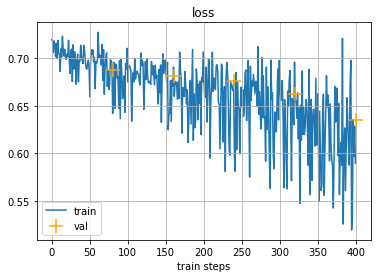

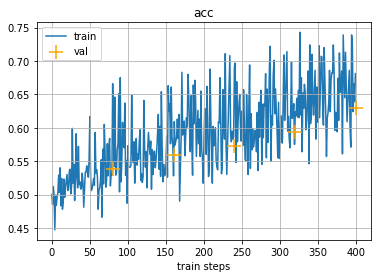

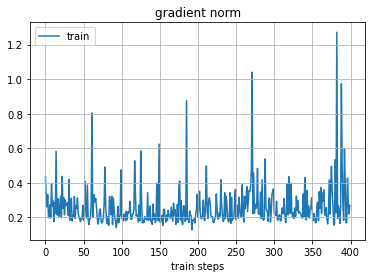

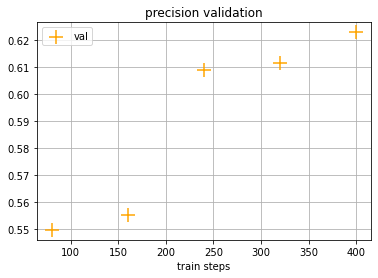

In [47]:
#run model and test

train_val(model,opt,train_options)

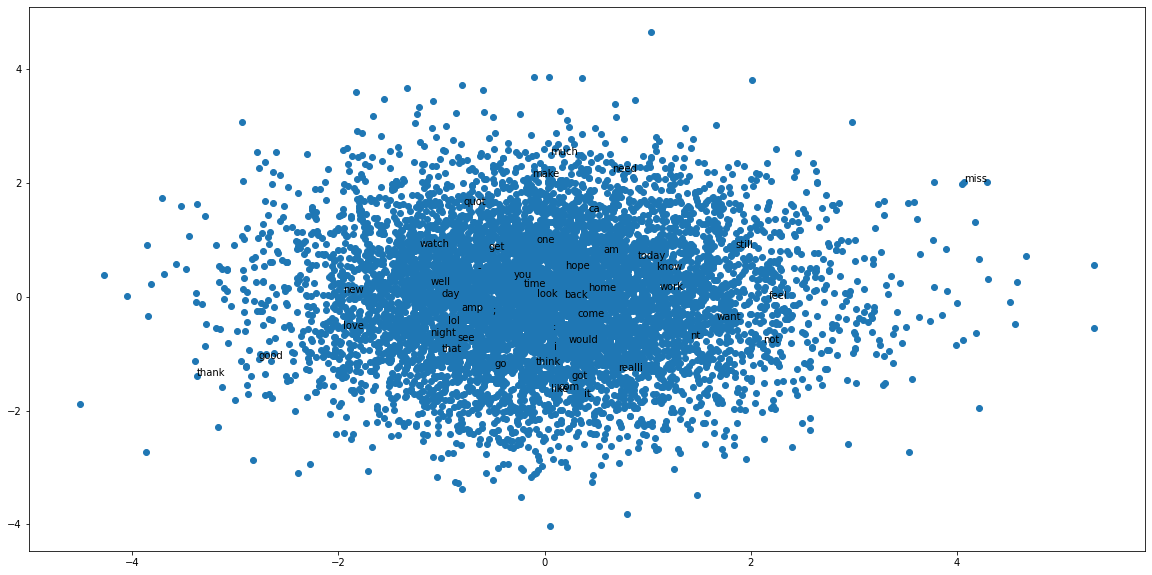

In [91]:
plot_pca(model)

In [11]:
## pytorch CNN2D
# ======================


class CNN_2d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx, pretrain):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        if pretrain is not None:
            self.embedding.weight.data.copy_(pretrain) #turn off autograd?
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
            #text = [batch size, sent len]

            embedded = self.embedding(text)

            #embedded = [batch size, sent len, emb dim]

            embedded = embedded.unsqueeze(1)

            #embedded = [batch size, 1, sent len, emb dim]

            conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

            #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

            #pooled_n = [batch size, n_filters]

            cat = self.dropout(torch.cat(pooled, dim = 1))

            #cat = [batch size, n_filters * len(filter_sizes)]
            
            cat = self.fc(cat)
            
            cat = torch.sigmoid(cat)
            
            return cat
           



In [13]:
## instantiate CNN2d and test

INPUT_DIM = len(text_field.vocab)+1
EMBEDDING_DIM = 100
PRETRAINED_EMBEDDINGS = None # || set to None otherwise
OUTPUT_DIM = 1
PAD_IDX = text_field.vocab.stoi[text_field.unk_token] ## passed to embedding layer to set 0 vector
DROPOUT = 0.5
N_FILTERS = 32
FILTER_SIZES = [2,3,4]

EPOCHS = 5

train_options = dict(EPOCHS=EPOCHS, clip=False, KERN_SET=KERNEL_SIZE)

model2d = CNN_2d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX, PRETRAINED_EMBEDDINGS)

opt2d = optim.Adam(model2d.parameters())

criterion = nn.BCELoss() 


print(f'The model has {count_parameters(model2d):,} trainable parameters')

print(model2d)

print(train_options)


NameError: name 'KERNEL_SIZE' is not defined

In [155]:
#gridsearch param tuning

GRID_DROPOUT = [.5, .75, .4]
GRID_FILTERS = [32, 64, 128, 16]
GRID_EMBEDDINGS = [None]
GRID_EMBED_DIM = [100,50,300]
GRID_OPT_SELECT = ["Adam","RMSprop"]

#create list instantiated models with param tuning

GRID_TOTAL = [] 

for perm in itertools.product(GRID_DROPOUT, GRID_FILTERS, GRID_EMBEDDINGS, GRID_EMBED_DIM, GRID_OPT_SELECT):
    GRID_TOTAL.append(perm)

    
len(GRID_TOTAL)

GRID_TOTAL[0] # dropout x filter x embedding x embed_dim x optimizer_type

GRID_MODELS = []
GRID_OPT = []

#create models list

for i in range(len(GRID_TOTAL)):
    
    DROPOUT = GRID_TOTAL[i][0]
    N_FILTERS = GRID_TOTAL[i][1]
    PRETRAINED_EMBEDDINGS = GRID_TOTAL[i][2]
    EMBEDDING_DIM = GRID_TOTAL[i][3]
    
    GRID_MODELS.append(CNN_2d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX, PRETRAINED_EMBEDDINGS))
    GRID_OPT.append(eval("optim."+GRID_TOTAL[i][4])(GRID_MODELS[i].parameters()))

72

(0.5, 32, None, 100, 'Adam')

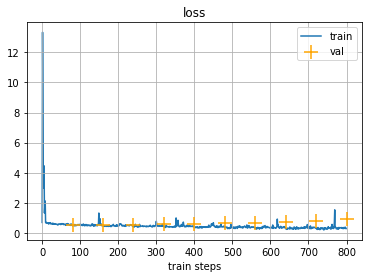

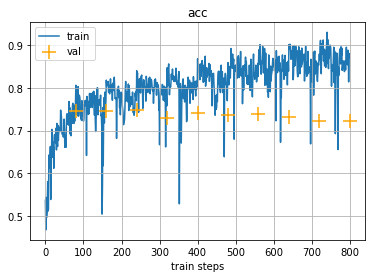

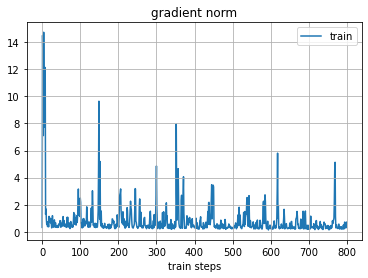

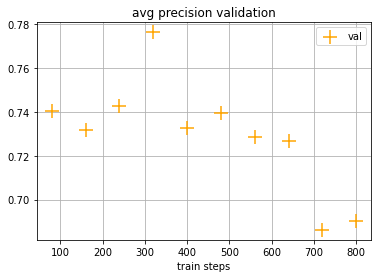

In [156]:
## RUN Heuristics Gridsearch here

GRID_TRACKER = []

#gradient does not exhibit high magnitudes, thus clip set to FALSE
#pre-trained embeddings from CNN1d exhibited no accuracy benefit, thus self-train embeddings
train_options = dict(EPOCHS=10, clip=False, KERN_SET=KERNEL_SIZE)

for i in range(len(GRID_MODELS)):
    print(" \n Running Grid search model %d of %d" % (i+1, len(GRID_MODELS)))
    temp_val = train_val(GRID_MODELS[i],GRID_OPT[i],train_options)
    GRID_TRACKER.append(np.max([temp_val[x][1] for x in range(len(temp_val))]))




In [159]:
#grid tracker results

GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))]; np.max(GRID_TRACKER)

print("mean: %f and std dev: %f " % (np.mean(GRID_TRACKER), np.std(GRID_TRACKER)))

(0.75, 64, None, 300, 'Adam')

0.7617999941110611

mean: 0.751660 and std dev: 0.005044 


(array([0.02777778, 0.01388889, 0.05555556, 0.18055556, 0.13888889,
        0.08333333, 0.18055556, 0.20833333, 0.08333333, 0.02777778]),
 array([0.7385    , 0.74083   , 0.74316   , 0.74549   , 0.74782   ,
        0.75015   , 0.75247999, 0.75480999, 0.75713999, 0.75946999,
        0.76179999]),
 <a list of 10 Patch objects>)

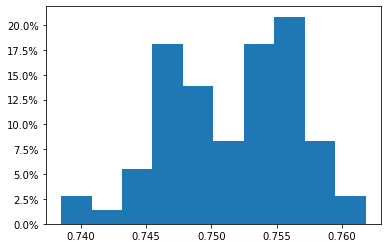

In [163]:
#grid tracker results histogram normalized

plt.hist(GRID_TRACKER, weights=np.ones(len(GRID_TRACKER)) / len(GRID_TRACKER))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()



In [12]:
#select best model and train / save

## instantiate CNN2d and test

INPUT_DIM = len(text_field.vocab)+1
EMBEDDING_DIM = 100
PRETRAINED_EMBEDDINGS = None # || set to None otherwise
OUTPUT_DIM = 1
PAD_IDX = text_field.vocab.stoi[text_field.unk_token] ## passed to embedding layer to set 0 vector
DROPOUT = 0.5
N_FILTERS = 32
FILTER_SIZES = [2,3,4]

EPOCHS = 10

train_options = dict(EPOCHS=EPOCHS, clip=False, KERN_SET=KERNEL_SIZE)

model2d = CNN_2d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX, PRETRAINED_EMBEDDINGS)

opt2d = optim.Adam(model2d.parameters())

criterion = nn.BCELoss() 


print(f'The model has {count_parameters(model2d):,} trainable parameters')

print(model2d)

print(train_options)




The model has 829,193 trainable parameters
CNN_2d(
  (embedding): Embedding(8002, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=96, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
{'EPOCHS': 10, 'clip': False, 'KERN_SET': [2, 3, 4]}


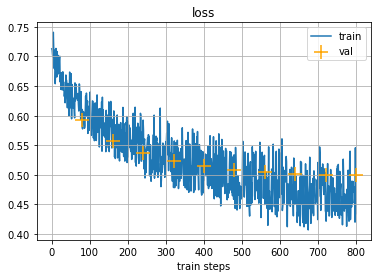

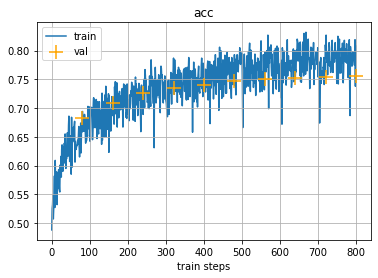

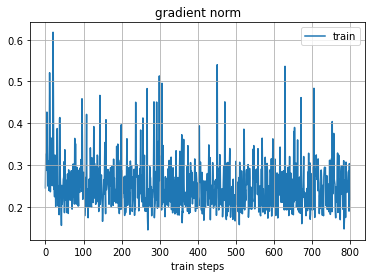

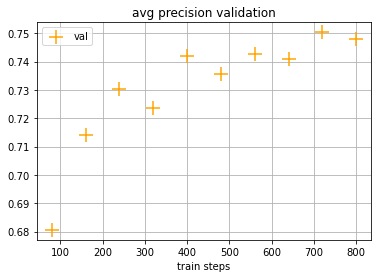

[(80, 0.6828499943017959),
 (160, 0.7084999948740005),
 (240, 0.7255499988794327),
 (320, 0.7341999977827072),
 (400, 0.7405499964952469),
 (480, 0.7474999994039535),
 (560, 0.7497999966144562),
 (640, 0.7529500007629395),
 (720, 0.753600001335144),
 (800, 0.755050003528595)]

In [13]:
train_val(model2d,opt2d,train_options)

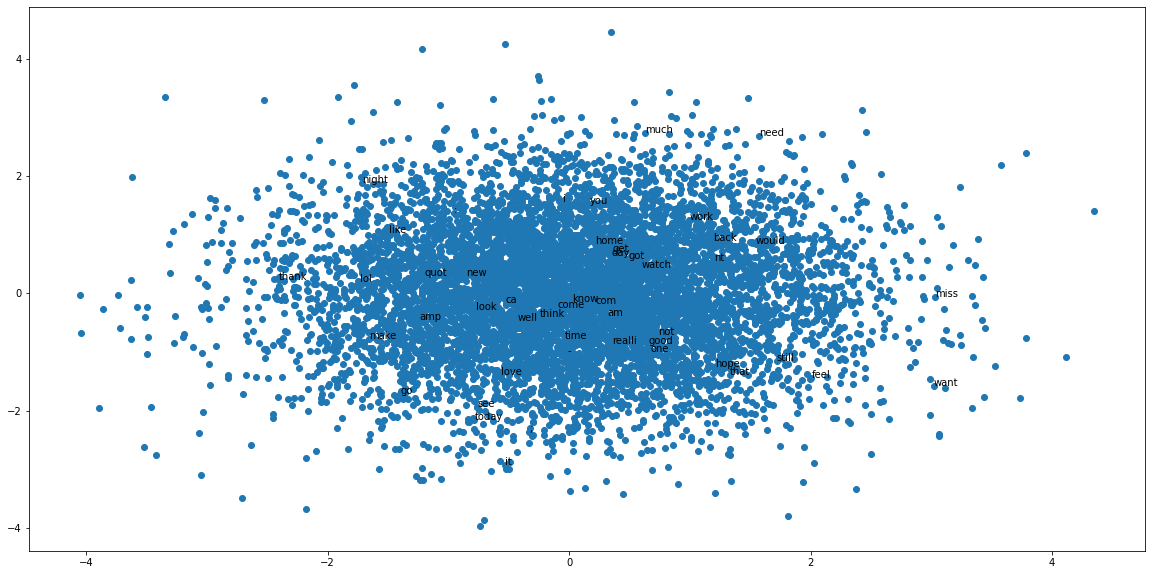

In [14]:
plot_pca(model2d)

In [15]:
nlp = spacy.load('en')

def predict(model, text, tokenized=True):
    """
    Given a tweet, predict the sentiment.

    text - a string or a a list of tokens
    tokenized - True if text is a list of tokens, False if passing in a string
    """

    # Sets the model to evaluation mode
    model.eval()

    if tokenized == False:
        # Tokenizes the sentence
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text

    # Index the tokens by converting to the integer representation from the vocabulary
    indexed_tokens = [text_field.vocab.stoi[t] for t in tokens]
    # Get the length of the text
    length = [len(indexed_tokens)]
    # Convert the indices to a tensor
    tensor = torch.LongTensor(indexed_tokens).to(device)
    # Add a batch dimension by unsqueezeing
    tensor = tensor.unsqueeze(1)
    tensor = tensor.T #transpose for passing into CNN2D
    
    if tensor.shape[1] < max(KERNEL_SIZE):
        tdata = tensor.detach()
        taddy = torch.zeros([tdata.shape[0], max(KERNEL_SIZE) - tdata.shape[1]])
        fin = torch.cat((tdata,taddy),dim=1)
        data = fin.type(torch.LongTensor)
        tensor = data
    
    # Converts the length into a tensor
    length_tensor = torch.LongTensor(length)
    # Convert prediction to be between 0 and 1 with the sigmoid function
    prediction = model(tensor)

    # Return a single value from the prediction
    return prediction.item()

In [16]:
fields = [('Tweet', text_field), ('Subjectivity',None),('Date',None),('Polarity',None),
      ('Sentiment',label_field)]

# Apply field definition to create torch dataset
testdf = torchtext.data.TabularDataset(
        path="trump_tweets_v3.csv",
        format="CSV",
        fields=fields,
        skip_header=True)

In [22]:
d = []


for idx in range(len(testdf)):

    # Detokenize the tweets from the test set
    tweet = TreebankWordDetokenizer().detokenize(testdf[idx].Tweet)
                                                 
    # Append tweet, prediction, and true label
    d.append({'Tweet': tweet, 'Prediction': predict(model2d, testdf[idx].Tweet), 'True_Label': testdf[idx].Sentiment})

# Convert list to dataframe
newdf = pd.DataFrame(d)
newdf['cnn2dpredict'] = newdf.Prediction.apply(lambda x: "Positive" if x >= .50 else "Negative")

In [27]:
newdf

,Tweet,Prediction,True_Label,cnn2dpredict
0,i was thrilled to be back in the great city of...,0.74499,Positive,Positive
1,read: letter to surveillance court obtained by...,0.49877,Positive,Negative
2,the unsolicited mail in ballot scam is a major...,0.28829,Positive,Negative
3,very friendly telling of events here about com...,0.73766,Positive,Positive
4,president announced historic steps to protec...,0.39305,Positive,Negative
...,...,...,...,...
5938,one of my greatest honors was to have gotten c...,0.63444,Positive,Positive
5939,magnificent trump- keeping his promises ðº...,0.62808,Positive,Positive
5940,congratulations sleepy joe! you just won stupi...,0.55111,Negative,Positive
5941,dear stupid people- peace is a good thingputin...,0.66707,Negative,Positive


In [29]:
print("CNN2d accuracy on Trump tweets: %f " % (np.sum(newdf.True_Label == newdf.cnn2dpredict) / newdf.shape[0]))

CNN2d accuracy on Trump tweets: 0.695945 
